In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style()

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os, sys, time
import cPickle as pickle
sys.path.append('../EXP/')
import ClevelandMcGill as C
reload(C)

<module 'ClevelandMcGill' from '../EXP/ClevelandMcGill/__init__.pyc'>

In [3]:
NOISE = False

In [101]:
train_target = 60000
val_target = 20000
test_target = 20000

X_train = np.zeros((train_target, 100, 100), dtype=np.float32)
y_train = np.zeros((train_target), dtype=np.float32)
train_counter = 0

X_val = np.zeros((val_target, 100, 100), dtype=np.float32)
y_val = np.zeros((val_target), dtype=np.float32)
val_counter = 0

X_test = np.zeros((test_target, 100, 100), dtype=np.float32)
y_test = np.zeros((test_target), dtype=np.float32)
test_counter = 0

t0 = time.time()

all_counter = 0
while train_counter < train_target or val_counter < val_target or test_counter < test_target:
  
  all_counter += 1
  
  sparse, image, label, parameters = C.Figure1.angle()
  
  if label == 0:
    break
  
  # we need float
  image = image.astype(np.float32)
  
  pot = np.random.choice(3, p=([.6,.2,.2]))

  if pot == 0 and train_counter < train_target:
    # a training candidate
    if label in y_val or label in y_test:
      # no thank you
      continue
      
    # add noise?
    if NOISE:
      image += np.random.uniform(0, 0.05,(100,100))
      
    # safe to add to training
    X_train[train_counter] = image
    y_train[train_counter] = label
    train_counter += 1
    
  elif pot == 1 and val_counter < val_target:
    # a validation candidate
    if label in y_train or label in y_test:
      # no thank you
      continue
      
    # add noise?
    if NOISE:
      image += np.random.uniform(0, 0.05,(100,100))
      
    # safe to add to validation
    X_val[val_counter] = image
    y_val[val_counter] = label
    val_counter += 1
  
  elif pot == 2 and test_counter < test_target:
    # a test candidate
    if label in y_train or label in y_val:
      # no thank you
      continue
      
    # add noise?
    if NOISE:
      image += np.random.uniform(0, 0.05,(100,100))
      
    # safe to add to test
    X_test[test_counter] = image
    y_test[test_counter] = label
    test_counter += 1
  
  
  
print 'Done', time.time()-t0, 'seconds (', all_counter, 'iterations)'

Done 85.7276749611 seconds ( 499145 iterations)


In [109]:
X_min = min(X_train.min(), X_val.min(), X_test.min())
X_max = max(X_train.max(), X_val.max(), X_test.max())
y_min = min(y_train.min(), y_val.min(), y_test.min())
y_max = max(y_train.max(), y_val.max(), y_test.max())

# scale in place
X_train -= X_min
X_train /= (X_max - X_min)
X_val -= X_min
X_val /= (X_max - X_min)
X_test -= X_min
X_test /= (X_max - X_min)
y_train -= y_min
y_train /= (y_max - y_min)
y_val -= y_min
y_val /= (y_max - y_min)
y_test -= y_min
y_test /= (y_max - y_min)

# normalize to -.5 .. .5
X_train -= .5
X_val -= .5
X_test -= .5

print 'memory usage', (X_train.nbytes + X_val.nbytes + X_test.nbytes + y_train.nbytes + y_val.nbytes + y_test.nbytes) / 1000000., 'MB'

memory usage 4000.4 MB


In [110]:
X_train_3D = np.stack((X_train,)*3, -1)
X_val_3D = np.stack((X_val,)*3, -1)
X_test_3D = np.stack((X_test,)*3, -1)
print 'memory usage', (X_train_3D.nbytes + X_val_3D.nbytes + X_test_3D.nbytes) / 1000000., 'MB'

memory usage 12000.0 MB


In [111]:
import keras.applications

VGG19 = keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=(100,100,3))

t0 = time.time()
X_train_3D_features = VGG19.predict(X_train_3D, verbose=True)
X_val_3D_features = VGG19.predict(X_val_3D, verbose=True)
X_test_3D_features = VGG19.predict(X_test_3D, verbose=True)
print 'VGG19 features done after', time.time()-t0
print 'memory usage', (X_train_3D_features.nbytes + X_val_3D_features.nbytes + X_test_3D_features.nbytes) / 1000000., 'MB'

Using TensorFlow backend.


20000/20000 [==============================] - 57s 3ms/step
VGG19 features done after 276.150902987
memory usage 1843.2 MB


In [112]:
feature_shape = X_train_3D_features.shape[1] * X_train_3D_features.shape[2] * X_train_3D_features.shape[3]

In [113]:
from keras import models
from keras import layers
from keras import optimizers
import keras.applications
from keras import backend as K
from keras.utils.np_utils import to_categorical

MLP = models.Sequential()

MLP.add(layers.Dense(256, activation='relu', input_dim=feature_shape))
MLP.add(layers.Dropout(0.5))
MLP.add(layers.Dense(1, activation='linear')) # REGRESSION

sgd = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
MLP.compile(loss='mean_squared_error', optimizer=sgd, metrics=['mse', 'mae']) # MSE for regression

In [114]:
t0 = time.time()
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')]

history = MLP.fit(X_train_3D_features.reshape(X_train_3D_features.shape[0], feature_shape), \
                  y_train, \
                  epochs=1000, \
                  batch_size=32, \
                  validation_data=(X_val_3D_features.reshape(X_val_3D_features.shape[0], feature_shape), y_val),
                  callbacks=callbacks,
                  verbose=True)
print 'Fitting done', time.time()-t0

Train on 60000 samples, validate on 20000 samples
Epoch 1/1000
60000/60000 [==============================] - 9s 150us/step - loss: 0.0487 - mean_squared_error: 0.0487 - mean_absolute_error: 0.1650 - val_loss: 0.0185 - val_mean_squared_error: 0.0185 - val_mean_absolute_error: 0.1041
Epoch 2/1000
60000/60000 [==============================] - 9s 146us/step - loss: 0.0227 - mean_squared_error: 0.0227 - mean_absolute_error: 0.1174 - val_loss: 0.0134 - val_mean_squared_error: 0.0134 - val_mean_absolute_error: 0.0865
Epoch 3/1000
60000/60000 [==============================] - 9s 146us/step - loss: 0.0174 - mean_squared_error: 0.0174 - mean_absolute_error: 0.1017 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0736
Epoch 4/1000
60000/60000 [==============================] - 9s 145us/step - loss: 0.0147 - mean_squared_error: 0.0147 - mean_absolute_error: 0.0932 - val_loss: 0.0078 - val_mean_squared_error: 0.0078 - val_mean_absolute_error: 0.0646
Epoch 5/1000
6

Epoch 36/1000
60000/60000 [==============================] - 9s 146us/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0517 - val_loss: 0.0023 - val_mean_squared_error: 0.0023 - val_mean_absolute_error: 0.0355
Epoch 37/1000
60000/60000 [==============================] - 9s 146us/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0517 - val_loss: 0.0019 - val_mean_squared_error: 0.0019 - val_mean_absolute_error: 0.0328
Epoch 38/1000
60000/60000 [==============================] - 9s 146us/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0511 - val_loss: 0.0021 - val_mean_squared_error: 0.0021 - val_mean_absolute_error: 0.0337
Epoch 39/1000
60000/60000 [==============================] - 9s 146us/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0508 - val_loss: 0.0021 - val_mean_squared_error: 0.0021 - val_mean_absolute_error: 0.0336
Epoch 40/1000
60000/60000 [==============================] -

Epoch 71/1000
60000/60000 [==============================] - 9s 145us/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0467 - val_loss: 0.0015 - val_mean_squared_error: 0.0015 - val_mean_absolute_error: 0.0295
Epoch 72/1000
60000/60000 [==============================] - 9s 145us/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0466 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - val_mean_absolute_error: 0.0302
Epoch 73/1000
60000/60000 [==============================] - 9s 146us/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0464 - val_loss: 0.0015 - val_mean_squared_error: 0.0015 - val_mean_absolute_error: 0.0291
Epoch 74/1000
60000/60000 [==============================] - 9s 145us/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0463 - val_loss: 0.0014 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0282
Epoch 75/1000
60000/60000 [==============================] -

Epoch 106/1000
60000/60000 [==============================] - 9s 145us/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0442 - val_loss: 0.0015 - val_mean_squared_error: 0.0015 - val_mean_absolute_error: 0.0285
Epoch 107/1000
60000/60000 [==============================] - 9s 145us/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0438 - val_loss: 0.0013 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0268
Epoch 108/1000
60000/60000 [==============================] - 9s 145us/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0440 - val_loss: 0.0016 - val_mean_squared_error: 0.0016 - val_mean_absolute_error: 0.0315
Epoch 109/1000
60000/60000 [==============================] - 9s 145us/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0439 - val_loss: 0.0012 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0259
Epoch 110/1000
60000/60000 [============================

In [115]:
y_pred = MLP.predict(X_test_3D_features.reshape(X_test_3D_features.shape[0], feature_shape))

In [116]:
import sklearn.metrics
np.log2(sklearn.metrics.mean_absolute_error(y_pred*100, y_test*100)+.125)

1.2652587762723027

In [102]:
np.unique(y_train)

array([  2.,   3.,   5.,   6.,  12.,  16.,  17.,  19.,  20.,  21.,  22.,
        23.,  24.,  26.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  36.,
        39.,  40.,  41.,  43.,  45.,  47.,  48.,  50.,  51.,  54.,  55.,
        56.,  57.,  58.,  61.,  64.,  65.,  66.,  71.,  73.,  76.,  77.,
        79.,  80.,  82.,  84.,  85.,  86.,  87.,  89.,  90.], dtype=float32)

In [103]:
np.unique(y_val)

array([  1.,   7.,   8.,  10.,  13.,  25.,  37.,  38.,  46.,  49.,  52.,
        59.,  63.,  67.,  68.,  70.,  74.,  78.,  88.], dtype=float32)

In [104]:
np.unique(y_test)

array([  4.,   9.,  11.,  14.,  15.,  18.,  27.,  35.,  42.,  44.,  53.,
        60.,  62.,  69.,  72.,  75.,  81.,  83.], dtype=float32)

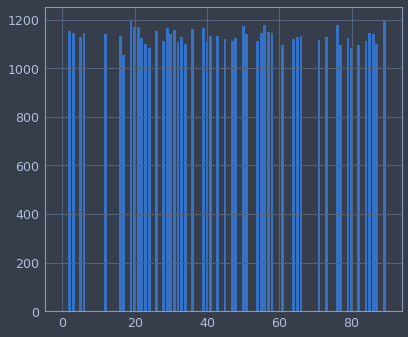

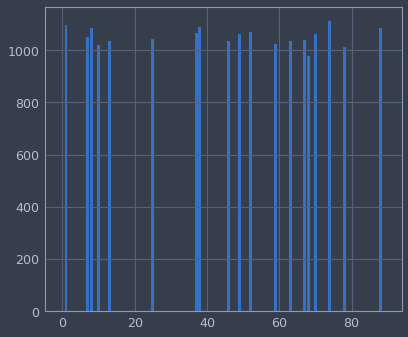

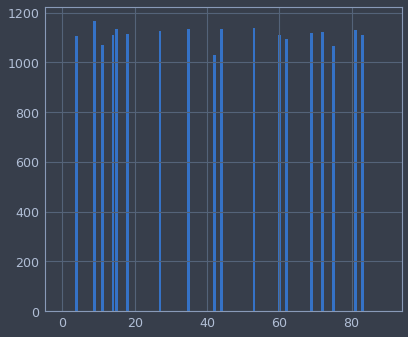

In [105]:
for whichone in [y_train, y_val, y_test]:

  data = []
  for i in range(90):
    data.append(len(np.where(whichone==i)[0]))
  plt.figure()
  plt.bar(range(90), data)